## 載入前處理

In [2]:
!wget -c https://github.com/1010code/keyword-transformer/raw/main/data/mean.txt -P data
!wget -c https://github.com/1010code/keyword-transformer/raw/main/data/std.txt -P data
!wget -c https://github.com/1010code/keyword-transformer/raw/main/utils/mel_features.py -P utils

--2023-01-21 17:58:15--  https://github.com/1010code/keyword-transformer/raw/main/data/mean.txt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/1010code/keyword-transformer/main/data/mean.txt [following]
--2023-01-21 17:58:15--  https://raw.githubusercontent.com/1010code/keyword-transformer/main/data/mean.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2023-01-21 17:58:16--  https://github.com/1010code/keyword-transformer/raw/main/data/std.txt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (

In [3]:
import pandas as pd

mean = pd.read_csv("./data/mean.txt", sep=" ", header=None).values.reshape(98, 32)
std = pd.read_csv("./data/std.txt", sep=" ", header=None).values.reshape(98, 32)

In [2]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import mel_features

def load_wave(path):
    spf = wave.open(path, "r")
    # Extract Raw Audio from Wav File
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, "int16")
    return signal

def wave_normalize(signal):
    # scale to -1~1
    MIN=-32768
    MAX=32767;
    input_speech=[]
    for i in range(len(signal)):
        X_std = (signal[i] - MIN)*1. / (MAX - MIN)
        X_std = X_std * (1 - -1) + -1
        input_speech.append(X_std)
    return input_speech

def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)

    equal_length = tf.concat([waveform, zero_padding], 0)
    equal_length = equal_length.numpy().flatten()
    spectrogram = 30 * (
        mel_features.log_mel_spectrogram(
        equal_length,
            16000,
            log_offset=0.001,
            window_length_secs=0.025,
            hop_length_secs=0.010,
            num_mel_bins=32,
            lower_edge_hertz=60,
            upper_edge_hertz=3800) - np.log(1e-3))

    return spectrogram

def plot_wave(wave):
    plt.figure(figsize=(6,4))
    plt.plot(wave)
    plt.show()
    plt.figure(figsize=(6,4))
    plt.imshow(get_spectrogram(wave).T, cmap="inferno")
    plt.show()

## 載入 ONNX 模型

In [ ]:
!wget -c https://github.com/1010code/keyword-transformer/raw/main/data/tf_model.onnx -P data
!wget -c https://github.com/1010code/keyword-transformer/raw/main/data/0-1.wav -P data

In [ ]:
!pip install onnxruntime==1.12.1 -q

In [3]:
# Compute the prediction with ONNX Runtime
import onnxruntime as rt

sess = rt.InferenceSession("./data/tf_model.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
label_list = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

audio shape: (14861,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


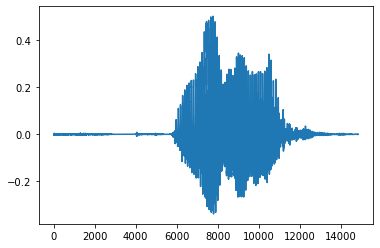

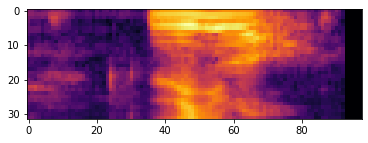

Predict: zero


In [13]:
# 讀取資料
signal = load_wave("./data/0-1.wav")
print(f'audio shape: {signal.shape}')
# 正規化
input_speech = wave_normalize(signal)
# 繪製音訊
plot_wave(input_speech)
# 取得頻譜＆前處理
data = get_spectrogram(input_speech)
data -= -mean
data /= std

# inference
pred_onx = sess.run([label_name], {input_name: np.array([data]).astype(np.float32)})[0]

print(f'Predict: {label_list[pred_onx.argmax()]}')